# Bonsai Boosted Decision Tree generator 
This script has been created to retrain PatLongLivedTracking's seed classifier.  
It also generates the c++ code that can be used within the PatLongLivedTracking class.   

The following script contains such steps as: 
1. Convert training NTuple into pandas DataFrame
2. Train the bonsai Boosted Decision Tree 
    * This script contains only final model training. The entire Machine Learning study contains model selection, tuning hyper-parameters and features engineering can be found [here](https://github.com/adendek/DownstreamTracking)
    * The bBDT is based on hep_ml.speedup.LookupClassifier with xgboost as a base classifier
3. Generate the tuple classifier (root file)
4. Generate C++ code. This code can be deployed into PatLongLivevTracking class.   



In [1]:
print ("kernel is alive!")

kernel is alive!


In [2]:
import root_numpy
import root_pandas
import pandas as pd
import itertools
import numpy
import matplotlib.pyplot as plt
import ROOT
%matplotlib inline

#sklearn imports 
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn import cross_validation
from sklearn.metrics import roc_curve, auc
from sklearn import grid_search

import xgboost as xgb

from hep_ml.speedup import LookupClassifier

Welcome to ROOTaaS 6.06/02


## As a very first step I need to convert training data from root NTpule into pandas DataFrame 

To obtain this goal I will use **root_numpy**, that allows me to convert root NTuple to pandas.Dataframe  
At first the training file name have to be defined

In [3]:
training_file_name = "datasets/Brunel_BdJPsiKs_MagU_30k.root"

In [4]:
root_file = ROOT.TFile(training_file_name)
root_file.cd("ToolSvc.PatDebugTTTruthTool")
tree = ROOT.gDirectory.Get("DownstreamSeedDebugTuple")
data = pd.DataFrame(root_numpy.tree2array(tree))

features = data.drop(["is_true_seed","has_MCParticle",
                      "is_downstream_reconstructible",
                      "has_MCParticle_not_electron",
                     "is_downstream_reconstructible_not_electron",
                     "seed_mva_value"] , axis=1).astype(numpy.float64)

target = data.is_downstream_reconstructible

features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
0,1.447929,1849.101146,1083.522737,27,0,12,-1418.736880,-143.095899,-0.722093,-0.038671
1,0.354945,10085.622823,1345.148537,24,0,12,-393.699553,-284.193871,-0.129122,-0.037920
2,2.906524,2441.534682,1013.888408,24,0,12,-834.004914,-270.235334,-0.456235,-0.015198
3,3.234916,2604.073941,904.097232,24,0,12,-475.119652,-230.380918,-0.369728,-0.018967
4,0.842265,2644.554049,1068.602364,23,0,12,-899.187260,-101.826800,-0.440227,-0.036610


In [5]:
momentum_grater_5GV = features[features.seed_p>5000]
momentum_grater_5GV.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
1,0.354945,10085.622823,1345.148537,24,0,12,-393.699553,-284.193871,-0.129122,-0.037920
9,1.879188,7168.990553,1161.375854,18,0,10,354.869485,-429.609191,0.155524,-0.052568
10,3.885850,6557.645783,1297.828112,18,0,11,-651.661886,-61.990891,-0.201860,0.004238
12,2.194147,12490.752519,1658.776470,20,0,11,544.057948,-62.587921,0.133723,-0.008409
13,1.328705,14385.018759,1315.787289,16,0,9,-290.457946,-89.084344,-0.091253,-0.010492


In [6]:
def basic_transforamtion(data):
    #abs transformation
    out = data
    out["abs_seed_x"]=numpy.abs(data['seed_x'])
    out["abs_seed_y"]=numpy.abs(data['seed_y'])
    out["abs_seed_tx"]=numpy.abs(data['seed_tx'])
    out["abs_seed_ty"]=numpy.abs(data['seed_ty'])
    out['seed_r'] = numpy.sqrt(numpy.square(data.seed_x) +numpy.square(data.seed_y))    
    out['pseudo_rapidity'] = numpy.arctanh(data.seed_pt/data.seed_p)
    return out

In [7]:
new_data = basic_transforamtion(data)
new_features =  new_data.drop(["is_true_seed","has_MCParticle",
                    "is_downstream_reconstructible",
                    "has_MCParticle_not_electron",
                    "is_downstream_reconstructible_not_electron",
                    "seed_mva_value",
                    "seed_x",
                    "seed_y",
                    "seed_tx",
                    "seed_ty"] , axis=1).astype(numpy.float64)

new_features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,abs_seed_x,abs_seed_y,abs_seed_tx,abs_seed_ty,seed_r,pseudo_rapidity
0,1.447929,1849.101146,1083.522737,27,0,12,1418.736880,143.095899,0.722093,0.038671,1425.935051,0.671511
1,0.354945,10085.622823,1345.148537,24,0,12,393.699553,284.193871,0.129122,0.037920,485.556891,0.134172
2,2.906524,2441.534682,1013.888408,24,0,12,834.004914,270.235334,0.456235,0.015198,876.693408,0.441959
3,3.234916,2604.073941,904.097232,24,0,12,475.119652,230.380918,0.369728,0.018967,528.028457,0.362240
4,0.842265,2644.554049,1068.602364,23,0,12,899.187260,101.826800,0.440227,0.036610,904.934487,0.428511


### Balance the training dataset

In [8]:
good_track_no = counts = new_features[target == 1].count()[0]
ghost_track_no = counts = new_features[target == 0].count()[0]
print("good tracks %d") % good_track_no
print("ghost track %d") % ghost_track_no
ratio_ghost_to_good = float(ghost_track_no)/good_track_no
ratio_ghost_to_good = numpy.round(ratio_ghost_to_good, 3)
print ("ratio ghost to good %f") % ratio_ghost_to_good

good tracks 1300187
ghost track 1115013
ratio ghost to good 0.858000


In [9]:
new_features = new_features.drop(["seed_nbIT","seed_nLayers"], axis=1).astype(numpy.float64)
new_features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,abs_seed_x,abs_seed_y,abs_seed_tx,abs_seed_ty,seed_r,pseudo_rapidity
0,1.447929,1849.101146,1083.522737,27,1418.736880,143.095899,0.722093,0.038671,1425.935051,0.671511
1,0.354945,10085.622823,1345.148537,24,393.699553,284.193871,0.129122,0.037920,485.556891,0.134172
2,2.906524,2441.534682,1013.888408,24,834.004914,270.235334,0.456235,0.015198,876.693408,0.441959
3,3.234916,2604.073941,904.097232,24,475.119652,230.380918,0.369728,0.018967,528.028457,0.362240
4,0.842265,2644.554049,1068.602364,23,899.187260,101.826800,0.440227,0.036610,904.934487,0.428511


## Train the bonsai Boosted Decision Tree classifier
As mentiond before the hyperparameters of the based classifier has beed selected in advance. 

In [10]:
train_X, test_X, train_Y, test_Y = train_test_split(new_features, target, random_state=42,train_size=0.8 )              

n_bins = 4

base_classifier = xgb.XGBClassifier(learning_rate=0.1, n_estimators=600, subsample=0.8, max_depth=6, nthread=10)
classifier = LookupClassifier(base_estimator=base_classifier, n_bins=n_bins, 
                              keep_trained_estimator=False )
classifier.fit(train_X, train_Y)

LookupClassifier(base_estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=600, nthread=10,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8),
         keep_trained_estimator=False, max_cells=500000000, n_bins=4)

### Check the model performance

In [11]:
print "ROC AUC score of binarized XGBoost with 400 trees and trained using scale positive weight"
roc_auc_score(test_Y, classifier.predict_proba(test_X)[:, 1])

ROC AUC score of binarized XGBoost with 400 trees and trained using scale positive weight


0.87004952267714653

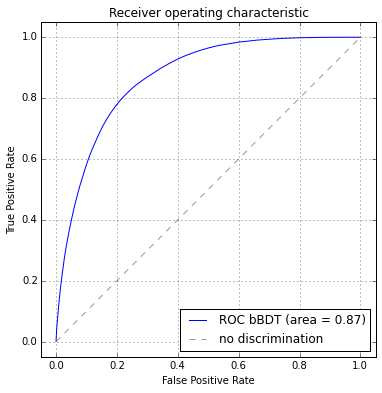

In [12]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(test_Y, classifier.predict_proba(test_X)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC bBDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

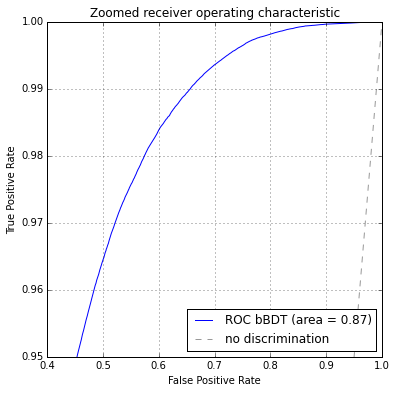

In [13]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(test_Y, classifier.predict_proba(test_X)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC bBDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([0.4, 1])
plt.ylim([0.95, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoomed receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [14]:
from sklearn.metrics import classification_report
target_names = ['background', "signal"]
print("classification raport test")
print(classification_report(test_Y, classifier.predict(test_X), target_names=target_names))


classification raport test
             precision    recall  f1-score   support

 background       0.80      0.74      0.77    223514
     signal       0.79      0.84      0.81    259526

avg / total       0.79      0.79      0.79    483040



In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
import numpy as np
def predict_vs_threshold(probas,threshold):
    probas_df = pd.DataFrame(probas[:, 1])
    predicted = np.where(probas_df>threshold,1,0)
    return predicted

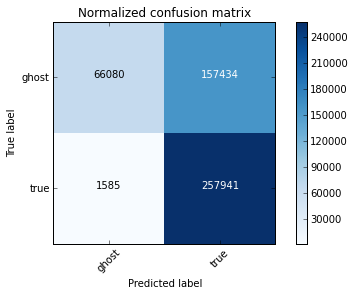

In [25]:
from sklearn.metrics import confusion_matrix
import itertools

   
threshold = 0.07

cnf_matrix = confusion_matrix(test_Y ,predict_vs_threshold(classifier.predict_proba(test_X),threshold));
target_names = ["ghost","true"]
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Normalized confusion matrix')


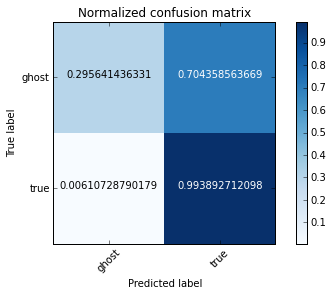

In [26]:
threshold = 0.07

cnf_matrix = confusion_matrix(test_Y ,predict_vs_threshold(classifier.predict_proba(test_X),threshold));
target_names = ["ghost","true"]
plot_confusion_matrix(cnf_matrix, classes=target_names,normalize=True,
                      title='Normalized confusion matrix')


In [19]:
print "Accurency"
accuracy_score(test_Y, predict_vs_threshold(classifier.predict_proba(test_X),threshold))

Accurency


0.72071050016561777

In [20]:
true_data = new_features[target==True]
true_data.tail()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,abs_seed_x,abs_seed_y,abs_seed_tx,abs_seed_ty,seed_r,pseudo_rapidity
2415185,1.574499,20320.608636,1571.315993,11,295.112276,68.782947,0.076946,0.009731,303.022028,0.077481
2415188,0.313083,28408.309891,1036.405936,12,40.336688,122.374996,0.032274,0.017063,128.851418,0.036499
2415189,0.951805,11858.867035,745.567330,12,29.083144,140.841257,0.060298,0.018233,143.812687,0.062953
2415192,2.301764,14785.201071,1569.749331,14,420.627710,97.083958,0.106640,0.005349,431.686189,0.106572
2415197,5.493763,1218.449560,927.026952,15,430.681559,318.414374,1.171714,0.039562,535.606497,0.998171


In [21]:
false_data =  new_features[target==False]
false_data.tail()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,abs_seed_x,abs_seed_y,abs_seed_tx,abs_seed_ty,seed_r,pseudo_rapidity
2415194,5.365714,1753.934213,600.593480,9,590.014028,192.425611,0.364410,0.006040,620.599846,0.356839
2415195,3.882290,15398.646030,1095.358650,15,36.277684,151.936796,0.020292,0.068366,156.207747,0.071254
2415196,0.517674,10882.713942,987.509216,14,157.202010,110.555525,0.089963,0.014454,192.184797,0.090991
2415198,6.951783,1321.739587,963.163094,14,741.718881,212.572602,1.064052,0.007970,771.578907,0.925968
2415199,3.939336,2541.411873,1144.469858,18,515.129341,1156.432056,0.469775,0.183561,1265.975251,0.485112


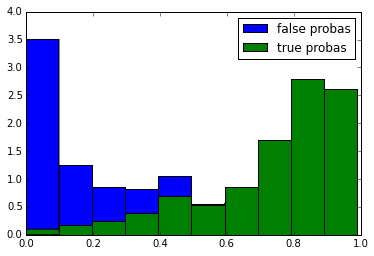

In [22]:
true_probas =  classifier.predict_proba(true_data)[:, 1]
false_probsa = classifier.predict_proba(false_data)[:, 1]
plt.hist(false_probsa, normed=1, label='false probas');
plt.hist(true_probas, normed=1, label='true probas');
plt.legend(loc="best");


Print the lookup table.
-------------
I want to see the structure of this array. 
I hope to find some structure. 

In [23]:
lookup_table = list(classifier._lookup_table[:,0])

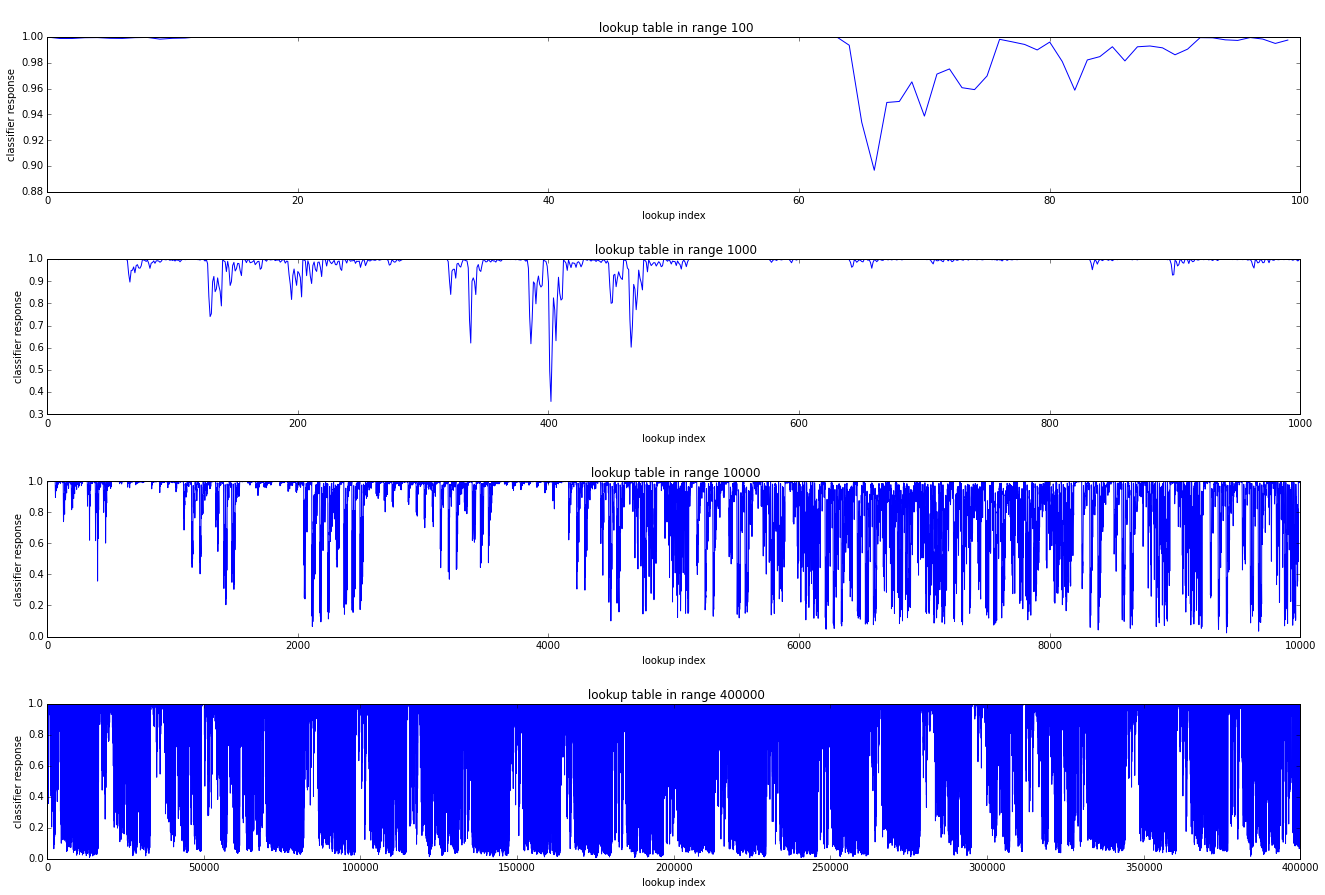

In [24]:
f, ax =  plt.subplots(4)
f.set_size_inches(18.5, 12.5)
ranges = [100,1000,10000,400000]
plot_it = 0
for plot_range in ranges:
    x = numpy.arange(0, plot_range)
    ax[plot_it].plot(x,lookup_table[:plot_range])
    ax[plot_it].set_title('\n lookup table in range %d'%plot_range)
    ax[plot_it].set_xlabel("lookup index")
    ax[plot_it].set_ylabel("classifier response")

    plot_it+=1
f.tight_layout() 


## The generation of the T-Seed classifier starts here

### Create the tuple classifier. 


In [64]:
n_features = new_features.shape[1]
all_bins_indices = list(itertools.product(range(n_bins), repeat=n_features)) 
all_bins_indices_df = pd.DataFrame(all_bins_indices,columns=new_features.columns.values )
all_bins_indices_df.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,abs_seed_x,abs_seed_y,abs_seed_tx,abs_seed_ty,seed_r,pseudo_rapidity
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,1,0


In [65]:
lookup_indices = classifier.convert_bins_to_lookup_index(all_bins_indices_df)
predictions = numpy.array(classifier._lookup_table[lookup_indices] [:,1])

all_bins_indices_df['pred'] = predictions
all_bins_indices_df.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,abs_seed_x,abs_seed_y,abs_seed_tx,abs_seed_ty,seed_r,pseudo_rapidity,pred
0,0,0,0,0,0,0,0,0,0,0,0.000151
1,0,0,0,0,0,0,0,0,0,1,0.001695
2,0,0,0,0,0,0,0,0,0,2,0.002032
3,0,0,0,0,0,0,0,0,0,3,0.000755
4,0,0,0,0,0,0,0,0,1,0,0.000970


### Save the tuple classifier as a root tree into file. 

In [63]:
!mkdir -p  models/cpp/
all_bins_indices_df.to_csv('models/cpp/BBDT_tuple_DR.csv', index=False)

## Generate classifer's c++ code

The next step is to generate source code of the class responsible for evaluation of the bBDT classifier.  
The template has been written manualy using CLion IDE.  

There will be 2 python function:
1. Generate header file (PatBBDTSeedClassifier.h)  
2. Generate cpp source  file (PatBBDTSeedClassifier.cpp)

In [59]:
def generate_header():
    return """
/** This file was generated automaticly by python script 
https://github.com/adendek/DownstreamTracking/blob/master/SeedClasifier/BDT-XGBoost.ipynb
DO NOT MODIFY IT MANUALLY!!!!!!
*/
    
#pragma once

#include "PatKernel/IPatMvaClassifier.h"
#include "PatKernel/IPatMvaClassifier.h"
#include "GaudiAlg/GaudiTool.h"

#include <vector>
#include <map>
#include <string>
#include <iostream>
#include <fstream>


class PatBBDTSeedClassifier : public GaudiTool, virtual public IPatMvaClassifier
{
public:
    PatBBDTSeedClassifier( const std::string& type,
                           const std::string& name,
                           const IInterface* parent);

    double getMvaValue(const std::vector<double>& parametersVector );

    virtual StatusCode initialize();

private:
//initialization phase
    void initBinEdgeMaps();
    void initTupleClassifier();
    
    int getIndex(const std::vector<double>& bins, double value);

    
    std::vector<int> getBinIndices(const std::vector<double>& parametersVector);
    std::vector<std::string> splitString(const std::string& toSplit, char token );
    void convertStringArrayToTuple(std::vector<std::string>& substrings, 
                                   std::vector<int>& indicesVector, double& prediction);

    // model prediction phase
    double getBBDTPrediction(const std::vector<int>& binIndices);


    std::vector <std::pair<std::string, std::vector<double>>> m_binsEdgeMap;
    std::map <std::vector<int>, double > m_tupleClassifier;
    std::ofstream debugFile;
};
"""

In [60]:
def generate_source_file():
    return """

#include "PatBBDTSeedClassifier.h"
#include <iostream>
#include <sstream>
#include <fstream>

DECLARE_TOOL_FACTORY( PatBBDTSeedClassifier )

using namespace std;


double PatBBDTSeedClassifier::getMvaValue(const std::vector<double>& parametersVector )
{
    auto binIndices = getBinIndices(parametersVector);
    double prediction = getBBDTPrediction(binIndices);
    for(const auto& bin: binIndices) debugFile<<bin<<" ";
    debugFile<<prediction<<endl;
    return prediction; 
}


PatBBDTSeedClassifier::PatBBDTSeedClassifier( const std::string& type,
                                                const std::string& name,
                                                const IInterface* parent )
        : GaudiTool ( type, name , parent )
{
    declareInterface<IPatMvaClassifier>(this);
}


StatusCode PatBBDTSeedClassifier::initialize()
{
    StatusCode sc =  GaudiTool::initialize();
    if(sc.isFailure()) return Error("Failed to initialize", sc);

    initBinEdgeMaps();
    initTupleClassifier();
    debugFile.open("Brunel_indices_debug.txt");
    return StatusCode::SUCCESS;
    
}

std::vector<int> PatBBDTSeedClassifier::getBinIndices(const std::vector<double>& parametersVector)
{
    std::vector<int> binIndices;
    int featureIt = 0;
    for (const auto& featurePair: m_binsEdgeMap){
      binIndices.push_back(getIndex(featurePair.second,parametersVector[featureIt]));
      featureIt++;
    }
    return binIndices;
}


int PatBBDTSeedClassifier::getIndex(const vector<double>& bins, double value)
{
  auto lower_bound = std::lower_bound(bins.begin(), bins.end(), value);
  return std::distance(bins.begin(),lower_bound);   
}


double PatBBDTSeedClassifier::getBBDTPrediction(const std::vector<int>& binIndices)
{
    return m_tupleClassifier[binIndices];
}

void PatBBDTSeedClassifier::initTupleClassifier() {
    
    ifstream file("/afs/cern.ch/user/a/adendek/lb_devs/BrunelDev_v52r0/Tf/PatAlgorithms/src/BBDT_tuple_DR_notel.csv", std::ifstream::in);
    // dodac sprawdzanie checksum aby byc pewnym ze jest dobra wartosc 
    std::string line;
    std::getline(file, line); // skip header
    std::cout<<"list of input features"<<line<<std::endl;
    // get the rest of the lines
    
    while (std::getline(file, line))
    {
        vector<string> substrings = splitString(line,',');
        vector<int> indices; 
        double prediction;
        convertStringArrayToTuple(substrings ,indices, prediction);
        m_tupleClassifier.insert(make_pair(indices, prediction));
    }
    
}

vector<string> PatBBDTSeedClassifier::splitString(const string& toSplit, char token )
{
    vector<string> subStrings;
    
    std::stringstream stringStream;
    stringStream.str(toSplit);
    std::string item;
    while (getline(stringStream, item, token)) {
        subStrings.push_back(item);
    }
    return subStrings;
}

void PatBBDTSeedClassifier::convertStringArrayToTuple(vector<string>& substrings, vector<int>& indicesVector, double& prediction)
{
    for(auto it= substrings.begin();it!= substrings.end()-1;it++ ){
        indicesVector.push_back(atoi((*it).c_str()));
    }
    prediction = atof((*(substrings.end()-1)).c_str());
}

"""

In [61]:
def generate_InitBinEdgeMap_function():
    function_body = """
void PatBBDTSeedClassifier::initBinEdgeMaps()
{
    m_binsEdgeMap ={
    """
    for feature, bins_edges in classifier.bin_edges.iteritems():
        function_body += "\t {\"" + str(feature) +"\", {"
        for bin_edge in bins_edges:
            function_body += str(bin_edge)+ ","
        function_body +=  "}},\n"
    
    function_body += """\n };
}
    """
    return function_body

In [62]:
file = open("models/cpp/PatBBDTSeedClassifier.h", 'w')
file.write(generate_header())
file.close()

file = open("models/cpp/PatBBDTSeedClassifier.cpp", 'w')
file_content = generate_source_file()
file_content += generate_InitBinEdgeMap_function()

file.write(file_content)
file.close()